In [30]:
import numpy as np
import pickle
import sys
import argparse
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
np.random.seed(1337)
import torch.backends.cudnn as cudnn
import torch, torch.nn as nn, math, torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
import os
import warnings
from collections import defaultdict
warnings.simplefilter("ignore", UserWarning)
from torch.nn import init

In [41]:
def data_load(model, shuffle = True, batchsize = 10, valid_size = 0.2):
    
    with open('./input/'+model+'.pickle', 'rb') as handle:
                (train_x, train_y, test_x, test_y, maxlen, train_len, test_len) = pickle.load(handle)
    train_len = np.array(train_len)
    test_len = np.array(test_len)
    
    train_x = torch.from_numpy(train_x).double()
    train_y = torch.from_numpy(train_y).double()
    test_x = torch.from_numpy(test_x).double()
    test_y = torch.from_numpy(test_y).double()
    train_len = torch.from_numpy(train_len)
    test_len = torch.from_numpy(test_len)
    
    num_train = len(train_x) 
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random_seed = 2018
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train = torch.utils.data.TensorDataset(train_x, train_y, train_len)
    test = torch.utils.data.TensorDataset(test_x, test_y, test_len)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size= batchsize, sampler=train_sampler, num_workers=2)
    valid_loader = torch.utils.data.DataLoader(train, batch_size= batchsize, sampler=valid_sampler, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test, batch_size= batchsize, shuffle= shuffle, num_workers=2)
    return train_loader, valid_loader, test_loader

In [48]:
class Unimodel(nn.Module):
    def __init__(self, input_size, drop_out, hidden_size = 300, out_size = 100):
        super(Unimodel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1,batch_first=True, bidirectional=True)
        for layer_p in self.lstm._all_weights:
            for p in layer_p:
                if 'weight' in p:
                    init.normal(self.lstm.__getattr__(p), 0.0, 0.02)
        self.dropout1 = nn.Dropout(p = 0.6)
        self.fc1 = nn.Linear(600,out_size) 
        self.dropout2 = nn.Dropout(p = drop_out)
        self.tanh = nn.Hardtanh(-1,1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(out_size, 2) 
       
    def forward(self, inputs, sequence_len): 
        
        pack = torch.nn.utils.rnn.pack_padded_sequence(inputs, sequence_len, batch_first=True)
        hidden = (
        Variable(torch.zeros(2, inputs.size(0), self.hidden_size),requires_grad=True),
        Variable(torch.zeros(2, inputs.size(0), self.hidden_size),requires_grad=True))
        
        out, hidden = self.lstm(pack, hidden)
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        
        output = self.dropout2(self.tanh(unpacked)) 
        inter1 = self.dropout2(self.relu(self.fc1(output))) 
        output = self.fc2(inter1) 
        
        return output, inter1

In [49]:
def sorted_sequence(input_x,sequences,y):
    # return the sorted sequence based on input_x
    diction = {}
    for i in range(int(sequences.size(0))):
        diction[i] = sequences[i]
    new_sequence = []
    new_x = torch.zeros(input_x.size(0),input_x.size(1),input_x.size(2))
    new_y = torch.zeros(y.size(0),y.size(1))
    count = 0
    for i, value in sorted(diction.items(), key=lambda x:x[1], reverse = True):
        new_sequence.append(int(value))
        new_x[count] = input_x[i]
        new_y[count] = y[i]
        count +=1
    return new_x,new_sequence,new_y

def cast_y(max_len, y):
    new_y = torch.zeros(y.size(0), max_len)
    for i in range(y.size(0)):
        new_y[i] = y[i][:max_len]
    return new_y

def save_model(net, optim, epoch, ckpt_fname):  
        state_dict = net.state_dict()                                                                                                                                                                         
        for key in state_dict.keys():                                                                                                                                                                                
            state_dict[key] = state_dict[key].cpu()                                                                                                                                                                                                                                                                                                                                                                               
        torch.save({                                                                                                                                                                                                 
            'epoch': epoch,                                                                                                                                                                                     
            'state_dict': state_dict,                                                                                                                                                                                
            'optimizer': optim},                                                                                                                                                                                     
            ckpt_fname)
        
def one_hot(train_y):
    maxlabel = 1
    new_y = torch.zeros((train_y.size(0),train_y.size(1), maxlabel+1))
    for i in range(int(train_y.size(0))):
        for j in range(int(train_y.size(1))):
            new_y[i,j,int(train_y[i,j])] = 1 
    return new_y
def generate_weight(sequence_length, y):
    mask = torch.zeros((y.size(0),y.size(1)))
    for i in range(y.size(0)):
        for j in range(sequence_length[i]):
            mask[i,j] = 1.0 
    return mask      

In [54]:
models = ['audio', 'video','text']
input_size = {'text': 100, 'audio': 73, 'video':100}
use_gpu = False
unimodal_activations = {}

train_loss = defaultdict(list)
train_acc = defaultdict(list)
test_loss = defaultdict(list)
test_acc = defaultdict(list)
valid_acc = defaultdict(list)
valid_loss = defaultdict(list)

unimodal_activations = {}
criterion = nn.CrossEntropyLoss(size_average = False)

def train_unimodel(epochs = 30, batch_size = 10, validation_split = 0.2, stop_early = 20, hidden_size = 300, dropout = 0.6):
    for mode in models:
        unimodal_activations = {}
        model = Unimodel(input_size[mode], dropout)
        #train_loader, valid_loader, test_loader = data_load(mode, 10, 0.2)
        if(use_gpu):
            model.cuda()
        optimizer = optim.Adagrad(params = model.parameters(), lr = 0.01)
        running_loss = 0
        total = 0
        correct = 0
        print('begin training for unimodel ' + mode)
        for epoch in range(epochs):
            train_loader, valid_loader, test_loader = data_load(mode, True, batch_size, validation_split)
            model.train(True)
            for e, data in enumerate(train_loader):
                optimizer.zero_grad()
                input_x, y, sequence_len = data[0], data[1], data[2]
                input_x, sequence_len, y = sorted_sequence(input_x,sequence_len, y)
                if use_gpu:
                    input_x = Variable(input_x.cuda(), requires_grad=True)
                else:
                    input_x = Variable(input_x, requires_grad=True)
                y = cast_y(sequence_len[0], y).long()
                if use_gpu:
                    y = Variable(y.cuda())
                predict_y, inter1 = model(input_x, sequence_len)
                loss = criterion(predict_y.view(-1,2), y.view(-1))/sum(sequence_len)
                _, predicted = torch.max(predict_y.view(-1,2).data, 1)
                train_mask = generate_weight(sequence_len, y)
                predicted = train_mask.view(-1).long() * predicted
                total += sum(sequence_len)
                correct += (predicted.data == y.view(-1).data).sum().int().data[0] - y.view(-1).size(0) + sum(sequence_len)
                running_loss += loss.data[0]
                
                loss.backward()
                optimizer.step()
            train_loss[mode].append( 1. * running_loss)
            train_acc[mode].append(1.* (correct.item()) /total)
            running_loss = 0
            correct = 0
            total = 0
            model.eval()
            for e, data in enumerate(valid_loader):
                    input_x, y, sequence_len = data[0], data[1], data[2]
                    input_x, sequence_len, y = sorted_sequence(input_x,sequence_len, y)
                    if use_gpu:
                        input_x = Variable(input_x.cuda(), requires_grad=False)
                    else:
                        input_x = Variable(input_x, requires_grad=False)
                    y = cast_y(sequence_len[0], y).long()
                    if use_gpu:
                        y = Variable(y.cuda())
                    predict_y, inter2 = model(input_x, sequence_len) 
                    loss = criterion(predict_y.view(-1,2), y.view(-1))/sum(sequence_len)
                    running_loss += loss.data[0]
                    _, predicted = torch.max(predict_y.view(-1,2).data, 1)
    
                    total += sum(sequence_len)
                    train_mask = generate_weight(sequence_len, y)
                    predicted = train_mask.view(-1).long() * predicted
                    correct += (predicted.data == y.view(-1).data).sum().int().data[0] - y.view(-1).size(0) + sum(sequence_len)
                    
            if(epoch %1 == 0):
                    print("epoch %d train acc %g valid acc % f" %(epoch, train_acc[mode][-1], 1.* correct.item()/total))
                    valid_loss[mode].append(1.*running_loss)
                    valid_acc[mode].append(1.* correct.item() /total)
                    running_loss = 0
                    correct = 0
                    total = 0
            for e, data in enumerate(test_loader):
                    input_x, y, sequence_len = data[0], data[1], data[2]
                    input_x, sequence_len, y = sorted_sequence(input_x,sequence_len, y)
                    if use_gpu:
                        input_x = Variable(input_x.cuda(), requires_grad = False)
                    else:
                        input_x = Variable(input_x, requires_grad = False)
                    y = cast_y(sequence_len[0], y).long()
                    if use_gpu:
                        y = Variable(y.cuda())
                    predict_y, inter2 = model(input_x, sequence_len) 
                    loss = criterion(predict_y.view(-1,2), y.view(-1))/sum(sequence_len)
                    _, predicted = torch.max(predict_y.view(-1,2).data, 1)
                    train_mask = generate_weight(sequence_len, y)
                    predicted = train_mask.view(-1).long() * predicted
                    total += sum(sequence_len)
                    correct += (predicted.data == y.view(-1).data).sum().int().data[0] - y.view(-1).size(0) + sum(sequence_len)
                    running_loss += loss.data[0]
                
            if epoch % 5 == 0:
                    print("test loss %f acc %g" %(running_loss, 1.* correct.item()/total))
            test_loss[mode].append(1.*running_loss)
            test_acc[mode].append(1.* correct.item()/total)
            running_loss = 0
            correct = 0
            total = 0
            if(stop_early!= epochs):
                if(epoch > stop_early and valid_acc[mode][-1] <= valid_acc[mode][-2] and valid_acc[mode][-2] <= valid_acc[mode][-3]):
                    print('stop early at %d' % epoch)
                    break
        filename = 'result/train_' + mode+ '_epoch_%d.dat' % (epoch +1)
        with open(filename,'w'):
            save_model(model, optimizer, epoch, filename)  
            
        train_loader, valid_loader, test_loader = data_load(mode, True, input_size[mode], 0)
        unimodal_activations = {}
        for i,data in enumerate(train_loader):
            input_x, y, sequence_len = data[0], data[1], data[2]
            input_x, sequence_len, y = sorted_sequence(input_x,sequence_len, y)
            input_x = Variable(input_x)
            y = cast_y(sequence_len[0], y).long()
            predict_y, inter1 = model(input_x, sequence_len)
            
            unimodal_activations['train'] = inter1
            unimodal_activations['train_len'] = sequence_len
            unimodal_activations['train_y'] = y
        for i,data in enumerate(test_loader):
            input_x, y, sequence_len = data[0], data[1], data[2]
            input_x, sequence_len, y = sorted_sequence(input_x,sequence_len, y)
            input_x = Variable(input_x)
            y = cast_y(sequence_len[0], y).long()
            predict_y, inter1 = model(input_x, sequence_len, False)
            unimodal_activations['test'] = inter1
            unimodal_activations['test_len'] = sequence_len
            unimodal_activations['test_y'] = y
        
        with open('result/' + mode + '_result_epoch_%_d.pickle' %(epoch +1), 'wb') as handle:
            result = defaultdict()
            result['train_loss'] = train_loss
            result['train_acc'] = train_acc
            result['test_loss'] = test_loss
            result['test_acc'] = test_acc
            result['valid_acc'] = valid_acc
            result['valid_loss'] = valid_loss
            pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('result/' + mode + '_unimodel%_d.pickle'%(epoch +1), 'wb') as handle:
            pickle.dump(unimodal_activations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
train_unimodel(epochs = 30, 
               batch_size = 10,
      validation_split = 0.2, 
      stop_early = 15, 
      hidden_size = 300, 
      dropout = 0.9) # text 0.783245 audio 0.378989 

begin training for unimodel audio
epoch 0 train acc 0.494382 valid acc  0.427586
test loss 4.496374 acc 0.378989
epoch 1 train acc 0.508211 valid acc  0.572414
epoch 2 train acc 0.487468 valid acc  0.427586
epoch 3 train acc 0.499568 valid acc  0.427586
epoch 4 train acc 0.520311 valid acc  0.427586
epoch 5 train acc 0.500432 valid acc  0.427586
test loss 4.233892 acc 0.378989
epoch 6 train acc 0.526361 valid acc  0.427586
epoch 7 train acc 0.522904 valid acc  0.427586


0
torch.Size([62, 55, 100])


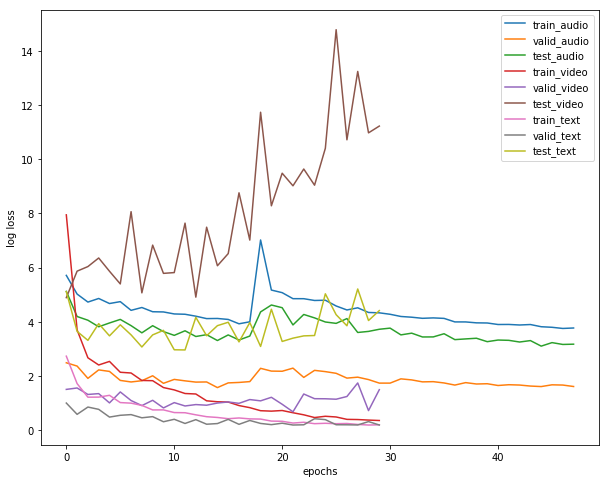

In [14]:
# loading the model individually and combine for training
# plot the result
import matplotlib.pyplot as plt
%matplotlib inline
filenames = ['result/audio_result_epoch_30.pickle', 'result/text_result_epoch_30.pickle', 'result/video_result_epoch_30.pickle']
result = defaultdict() 
for file in filenames:
    mode = file.split('/')[1].split('_')[0]
    with open(file, 'rb') as handle:
        result[mode] = pickle.load(handle)
modes = ['audio', 'video','text']

plt.figure(figsize=(10,8))
for mode in modes:
    train_loss = np.array(result[mode]['train_loss'][mode])
    valid_loss = np.array(result[mode]['valid_loss'][mode])
    test_loss = np.array(result[mode]['test_loss'][mode])
    plt.plot(train_loss, label = 'train_' + mode)
    plt.plot(valid_loss, label = 'valid_' + mode)
    plt.plot(test_loss, label = 'test_' + mode)
plt.xlabel("epochs")
plt.ylabel("log loss")
plt.legend()
plt.show()

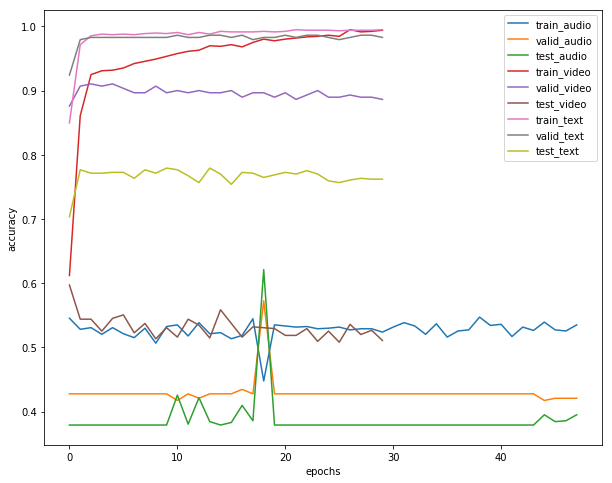

In [15]:
plt.figure(figsize=(10,8))
for mode in modes:
    train_loss = np.array(result[mode]['train_acc'][mode])
    valid_loss = np.array(result[mode]['valid_acc'][mode])
    test_loss = np.array(result[mode]['test_acc'][mode])
    plt.plot(train_loss, label = 'train_' + mode)
    plt.plot(valid_loss, label = 'valid_' + mode)
    plt.plot(test_loss, label = 'test_' + mode)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [19]:
# load the feature learned in the unimodal training
def multimodel_data_load(filenames, modes, batch_size = 10, valid_size = 0.2, shuffle = True):
    unimodal_activations = {}
    for file in filenames:
        mode = file.split('/')[1].split('_')[0]
        with open(file, 'rb') as handle:
            unimodal_activations[mode] = pickle.load(handle)
    if(len(modes) == 2):
        data_train1 = unimodal_activations[modes[0]]['train'].detach().numpy()
        data_train2 = unimodal_activations[modes[1]]['train'].detach().numpy()
        data_test1 = unimodal_activations[modes[0]]['test'].detach().numpy()
        data_test2 = unimodal_activations[modes[1]]['test'].detach().numpy()
        train_x = np.concatenate(data_train1,data_train2)
        test_x = np.concatenate(data_test1,data_test2)
        
    if(len(modes) == 3):
        train_x = np.concatenate((unimodal_activations['text']['train'].detach().numpy(), unimodal_activations['audio']['train'].detach().numpy(), unimodal_activations['video']['train'].detach().numpy()), axis=2)
        test_x = np.concatenate((unimodal_activations['text']['test'].detach().numpy(), unimodal_activations['audio']['test'].detach().numpy(), unimodal_activations['video']['test'].detach().numpy()), axis=2)

    train_len = np.array(unimodal_activations['text']['train_len'])
    train_y = unimodal_activations['text']['train_y'].detach().numpy()
    test_len = np.array(unimodal_activations['text']['test_len'])
    test_y = unimodal_activations['text']['test_y'].detach().numpy()
    
    train_x = torch.from_numpy(train_x).double()
    train_y = torch.from_numpy(train_y).double()
    test_x = torch.from_numpy(test_x).double()
    test_y = torch.from_numpy(test_y).double()
    train_len = torch.from_numpy(train_len)
    test_len = torch.from_numpy(test_len)
    
    num_train = len(train_x) 
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random_seed = 2018
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    #print(train_x.shape, train_y.shape, train_len.shape)
    train = torch.utils.data.TensorDataset(train_x, train_y, train_len)
    test = torch.utils.data.TensorDataset(test_x, test_y, test_len)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size= batch_size, sampler=train_sampler, num_workers=2)
    valid_loader = torch.utils.data.DataLoader(train, batch_size= batch_size, sampler=valid_sampler, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test, batch_size= batch_size, shuffle= True, num_workers=2)
    return train_loader, valid_loader, test_loader
#     return train_data,train_mask,train_y,test_data,test_mask,test_y

In [20]:
modes = ['text', 'video', 'audio']
filenames = ['result/audio_unimodel_30.pickle', 'result/text_unimodel_30.pickle', 'result/video_unimodel_30.pickle']
train_loader, valid_loader, test_loader = multimodel_data_load(filenames,modes)
#print(train_data.shape, test_data.shape)

In [22]:
class multiModel(nn.Module):
    def __init__(self, input_size, hidden_size = 300, out_size = 500):
        super(multiModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1,batch_first=True, bidirectional=True)
        for layer_p in self.lstm._all_weights:
            for p in layer_p:
                if 'weight' in p:
                    #print('initializing weight')
                    init.normal(self.lstm.__getattr__(p), 0.0, 0.02)
        self.dropout1 = nn.Dropout(p = 0.9)
        self.fc1 = nn.Linear(600,out_size) 
        self.dropout2 = nn.Dropout(p = 0.9)
        self.tanh = nn.Hardtanh(-1,1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(out_size, 2) 
       
    def forward(self, inputs, sequence_len): # input is 10 * 63 * 100
        # training details:
        pack = torch.nn.utils.rnn.pack_padded_sequence(inputs, sequence_len, batch_first=True)
        hidden = (
        Variable(torch.zeros(2, inputs.size(0), self.hidden_size),requires_grad=True),
        Variable(torch.zeros(2, inputs.size(0), self.hidden_size),requires_grad=True))

        out, hidden = self.lstm(pack, hidden)
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)

        output = self.dropout2(self.tanh(unpacked)) # apply drop out
        inter1 = self.dropout2(self.relu(self.fc1(output))) # 100
        output = self.fc2(inter1) # 2
        return output  

In [23]:
from collections import defaultdict
epochs = 30
models = ['audio', 'video','text']
use_gpu = False
unimodal_activations = {}

model = multiModel(300)
criterion = nn.CrossEntropyLoss(size_average = False)
optimizer = optim.Adagrad(params = model.parameters(), lr = 0.01)

train_loss = []
train_acc = []
test_loss = []
test_acc = []
valid_acc = []
valid_loss = []

def train_multimodel(epochs = 30, stop_early = 30):
        print("start training for multimodel")
        #train_loader, valid_loader, test_loader = data_load(mode, 10, 0.2)
        if(use_gpu):
            model.cuda()
        running_loss = 0
        total = 0
        correct = 0
        for epoch in range(epochs):
            train_loader, valid_loader, test_loader = multimodel_data_load(filenames,models)
            model.train()
            for e, data in enumerate(train_loader):
                optimizer.zero_grad()
                input_x, y, sequence_len = data[0], data[1], data[2]
                input_x, sequence_len, y = sorted_sequence(input_x,sequence_len, y)
                if use_gpu:
                    input_x = Variable(input_x.cuda(), requires_grad=True)
                else:
                    input_x = Variable(input_x, requires_grad=True)
                y = cast_y(sequence_len[0], y).long()
                if use_gpu:
                    y = Variable(y.cuda())
                predict_y = model(input_x, sequence_len)
                loss = criterion(predict_y.view(-1,2), y.view(-1))/sum(sequence_len)
                _, predicted = torch.max(predict_y.view(-1,2).data, 1)
                train_mask = generate_weight(sequence_len, y)
                predicted = train_mask.view(-1).long() * predicted
                total += sum(sequence_len)
                correct += (predicted.data == y.view(-1).data).sum().int().data[0] - y.view(-1).size(0) + sum(sequence_len)
                running_loss += loss.data[0]
                
                loss.backward()
                optimizer.step()
            train_loss.append(1.*running_loss)
            train_acc.append(1.* (correct.item()) /total)
            running_loss = 0
            correct = 0
            total = 0
            model.eval()
            for e, data in enumerate(valid_loader):
                    input_x, y, sequence_len = data[0], data[1], data[2]
                    input_x, sequence_len, y = sorted_sequence(input_x,sequence_len, y)
                    if use_gpu:
                        input_x = Variable(input_x.cuda(), requires_grad=False)
                    else:
                        input_x = Variable(input_x, requires_grad=False)
                    y = cast_y(sequence_len[0], y).long()
                    if use_gpu:
                        y = Variable(y.cuda())
                    predict_y = model(input_x, sequence_len) 
                    loss = criterion(predict_y.view(-1,2), y.view(-1))/sum(sequence_len)
                    running_loss += loss.data[0]
                    _, predicted = torch.max(predict_y.view(-1,2).data, 1)
    
                    total += sum(sequence_len)
                    train_mask = generate_weight(sequence_len, y)
                    predicted = train_mask.view(-1).long() * predicted
                    correct += (predicted.data == y.view(-1).data).sum().int().data[0] - y.view(-1).size(0) + sum(sequence_len)
                    
            
            print("epoch %d train acc %g valid acc % f" %(epoch, train_acc[-1], 1.* correct.item()/total))
            valid_loss.append(1.*running_loss)
            valid_acc.append(1.* correct.item() /total)
            running_loss = 0
            correct = 0
            total = 0
            for e, data in enumerate(test_loader):
                    input_x, y, sequence_len = data[0], data[1], data[2]
                    input_x, sequence_len, y = sorted_sequence(input_x,sequence_len, y)
                    if use_gpu:
                        input_x = Variable(input_x.cuda(), requires_grad=False)
                    else:
                        input_x = Variable(input_x, requires_grad=False)
                    y = cast_y(sequence_len[0], y).long()
                    if use_gpu:
                        y = Variable(y.cuda())
                    predict_y = model(input_x, sequence_len) 
                    loss = criterion(predict_y.view(-1,2), y.view(-1))/sum(sequence_len)
                    _, predicted = torch.max(predict_y.view(-1,2).data, 1)
                    train_mask = generate_weight(sequence_len, y)
                    predicted = train_mask.view(-1).long() * predicted
                    total += sum(sequence_len)
                    correct += (predicted.data == y.view(-1).data).sum().int().data[0] - y.view(-1).size(0) + sum(sequence_len)
                    running_loss += loss.data[0]
            if(stop_early!= epochs):
                if(epoch > stop_early and valid_acc[mode][-1] <= valid_acc[mode][-2] and valid_acc[mode][-2] <= valid_acc[mode][-3]):
                    print('stop early at %d' % epoch)
                    break
            if (epoch+1) % 2 == 0:
                    print("test loss %f acc %g" %(running_loss, 1.* correct.item()/total))
            test_loss.append(1.*running_loss)
            test_acc.append(1.* correct.item()/total)
            running_loss = 0
            correct = 0
            total = 0
        filename = 'result/train_multimodel_epoch_%d.dat' % (epoch +1)
        with open(filename,'w'):
            save_model(model, optimizer, epoch, filename) 
            
        with open('result/multimodel_result_epoch_%d.pickle' %(epoch +1), 'wb') as handle:
            result = defaultdict()
            result['train_loss'] = train_loss
            result['train_acc'] = train_acc
            result['test_loss'] = test_loss
            result['test_acc'] = test_acc
            result['valid_acc'] = valid_acc
            result['valid_loss'] = valid_loss
            pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
warnings.simplefilter("ignore", UserWarning)
train_multimodel(50,20)

start training for multimodel
epoch 0 train acc 0.646604 valid acc  0.975352
epoch 1 train acc 0.975064 valid acc  0.982394
test loss 3.927472 acc 0.780585
epoch 2 train acc 0.995701 valid acc  0.982394
epoch 3 train acc 0.990542 valid acc  0.982394
test loss 4.804842 acc 0.781915
epoch 4 train acc 0.994841 valid acc  0.985915
epoch 5 train acc 0.992261 valid acc  0.985915
test loss 5.528606 acc 0.776596
epoch 6 train acc 0.989682 valid acc  0.985915
epoch 7 train acc 0.993981 valid acc  0.985915
test loss 7.023895 acc 0.775266
epoch 8 train acc 0.996561 valid acc  0.985915
epoch 9 train acc 0.989682 valid acc  0.985915
test loss 6.760176 acc 0.777926
epoch 10 train acc 0.990542 valid acc  0.989437
epoch 11 train acc 0.993981 valid acc  0.989437
test loss 5.598247 acc 0.773936
epoch 12 train acc 0.995701 valid acc  0.989437
epoch 13 train acc 0.991402 valid acc  0.989437
test loss 6.178231 acc 0.769947
epoch 14 train acc 0.992261 valid acc  0.989437
epoch 15 train acc 0.995701 valid ac

Process Process-278:
Process Process-277:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", l

KeyboardInterrupt: 

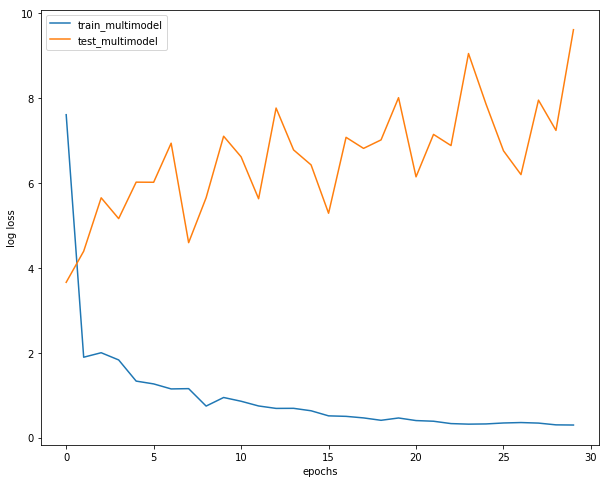

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
filenames = ['result/multimodel_result_epoch_30.pickle']
result = defaultdict() 
for file in filenames:
    mode = file.split('/')[1].split('_')[0]
    with open(file, 'rb') as handle:
        result[mode] = pickle.load(handle)
mode = "multimodel"
plt.figure(figsize=(10,8))
train_loss = np.array(result[mode]['train_loss'])
# valid_loss = np.array(result[mode]['valid_loss'])
test_loss = np.array(result[mode]['test_loss'])
plt.plot(train_loss, label = 'train_' + mode)
# plt.plot(valid_loss, label = 'validation_' + mode)
plt.plot(test_loss, label = 'test_' + mode)
plt.xlabel("epochs")
plt.ylabel("log loss")
plt.legend()
plt.show()

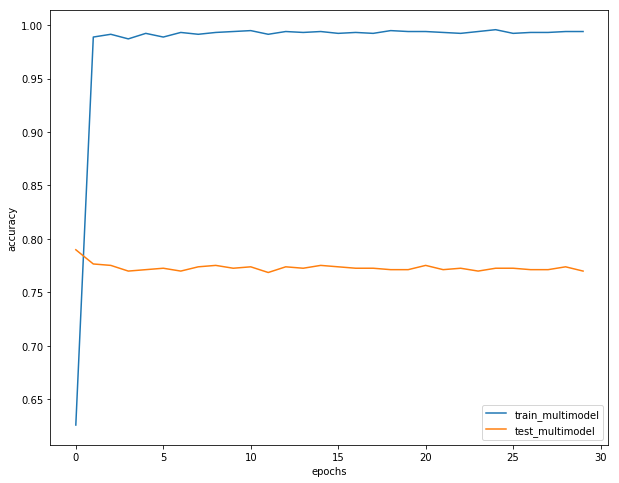

In [13]:
plt.figure(figsize=(10,8))
mode = "multimodel"
train_acc = np.array(result[mode]['train_acc'])
# valid_loss = np.array(result[mode]['valid_loss'])
test_acc = np.array(result[mode]['test_acc'])
plt.plot(train_acc, label = 'train_' + mode)
# plt.plot(valid_loss, label = 'validation_' + mode)
plt.plot(test_acc, label = 'test_' + mode)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()